In [33]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import itertools
import socket
from datetime import datetime
from pandas.tseries.offsets import DateOffset


import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from IPython.display import display
from IPython.display import clear_output

In [34]:
print(os.getcwd())

C:\Users\zanec\OneDrive\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums


In [35]:
# Declare important variables
train_path = 'train.csv'
solve_path = 'test.csv'
target_variable = 'Premium Amount'
SEED = 69

In [36]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    if socket.gethostname() == 'zchodani-p-l01':
        file_directory = r"C:\Users\zchodaniecky\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
    elif socket.gethostname() == 'FTILC3VBil7BwCe':
        file_directory = r"C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
    else:
        file_directory = r"C:\Users\zanec\OneDrive\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
         
    os.chdir(file_directory)

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    return df1, df2

In [37]:
df_train, df_solve = load_dataframes(train_path,solve_path)

In [38]:
df_train_id = df_train['id']
df_train = df_train.drop('id',axis=1)

df_solve_id = df_solve['id']
df_solve = df_solve.drop('id',axis=1)

In [39]:
from typing import Tuple

def plot_kde_grid(df: pd.DataFrame, n_cols: int = 4, figsize: Tuple[int, int] = (12,8)) -> None:
    """
    Plots KDE for all numeric columns in the dataframe in a grid layout.
    
    Parameters:
        df (pd.DataFrame): DataFrame with numeric columns to plot.
        n_cols (int): Number of columns in the grid (default is 3).
        figsize (tuple): Size of the entire figure (default is (12, 8)).
    
    Returns:
        None
    """
    # Get numeric columns
    numeric_cols = df.select_dtypes(include='number').columns
    
    # Set up grid size
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))  # Number of rows based on the number of features
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize))  # Adjust figure size
    axes = axes.flatten()  # Flatten to easily iterate
    
    # Plot each numeric column
    for i, col in enumerate(numeric_cols):
        sns.kdeplot(data=df, x=col, fill=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
    
    # Hide any unused subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

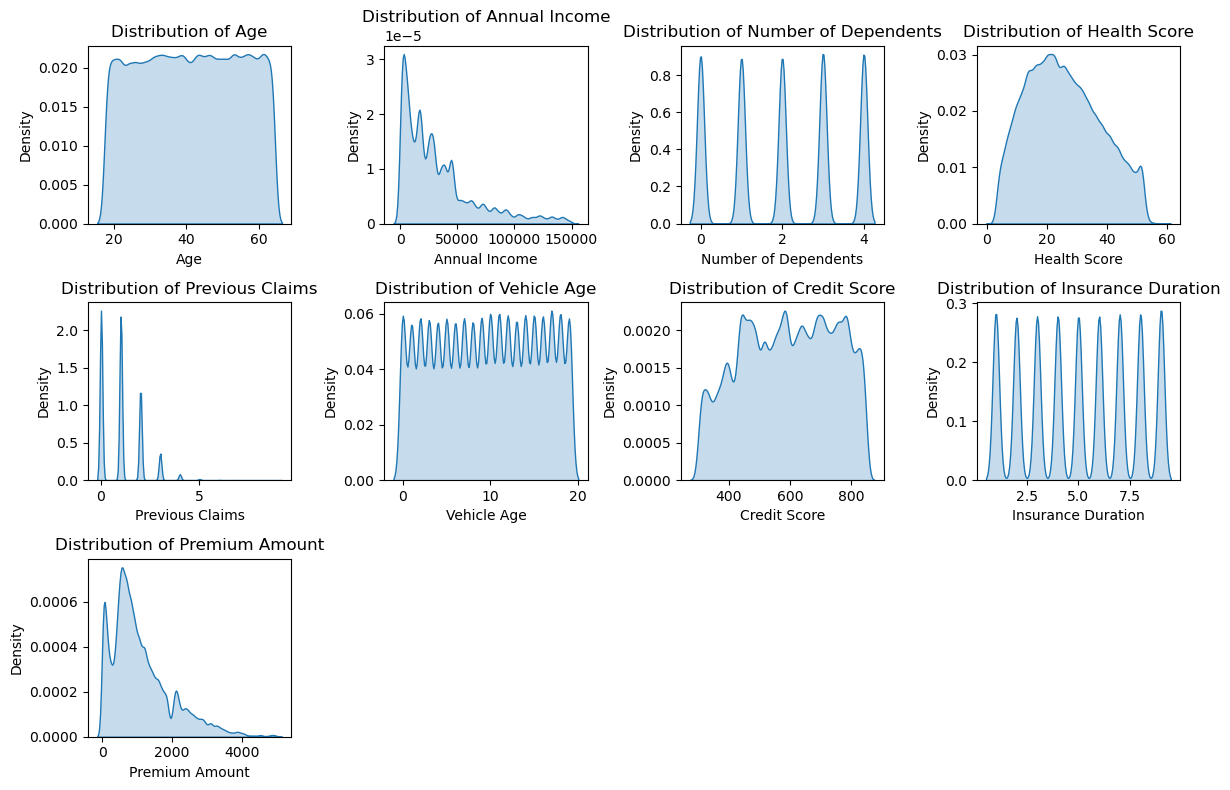

In [40]:
plot_kde_grid(df_train,n_cols=4,figsize=(12,8))

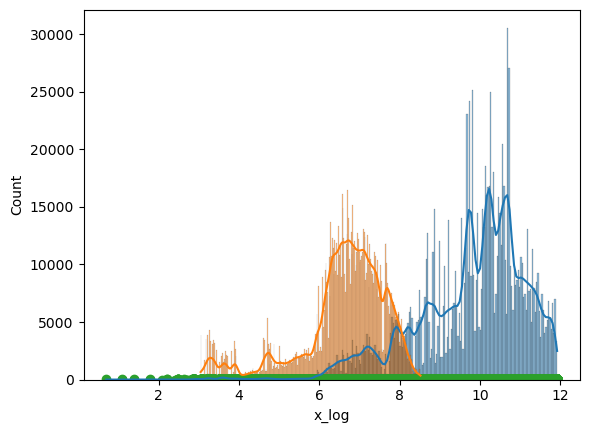

In [41]:
""" Annual Income and Premium Amount look to have some sort of correlation
    and both are right skew, lets look close
"""
df_hist = pd.DataFrame()
df_hist['x_log'] = np.log(df_train['Annual Income'] + 1)  # Add 1 to avoid log(0)
df_hist['y_log'] = np.log(df_train['Premium Amount'] + 1)  # Add 1 to avoid log(0)

# Plot histograms to check for skewness
sns.histplot(df_hist['x_log'], kde=True)
sns.histplot(df_hist['y_log'], kde=True)

# Scatter plot to check correlation between x and y
plt.scatter(df_hist['x_log'], df_hist['y_log'])
plt.show()

In [42]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
    # Plot unique values
    fig, ax = plt.subplots(1, 1, figsize=(24, 5))
    sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
    ax.set_title(f'{name} Unique Values')
    ax.bar_label(ax.containers[0])
    plt.tight_layout()
    plt.show()

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,18705,1.558750,47,0,18.000000,64.000000,41.145563,13.539950,nan,nan
1,Gender,object,0,0.000000,2,0,nan,nan,nan,nan,Male,602571
2,Annual Income,float64,44949,3.745750,88593,0,1.000000,149997.000000,32745.217777,32179.506124,nan,nan
3,Marital Status,object,18529,1.544083,3,0,nan,nan,nan,nan,Single,395391
4,Number of Dependents,float64,109672,9.139333,5,0,0.000000,4.000000,2.009934,1.417338,nan,nan
5,Education Level,object,0,0.000000,4,0,nan,nan,nan,nan,Master's,303818
6,Occupation,object,358075,29.839583,3,0,nan,nan,nan,nan,Employed,282750
7,Health Score,float64,74076,6.173000,532657,0,2.012237,58.975914,25.613908,12.203462,nan,nan
8,Location,object,0,0.000000,3,0,nan,nan,nan,nan,Suburban,401542
9,Policy Type,object,0,0.000000,3,0,nan,nan,nan,nan,Premium,401846


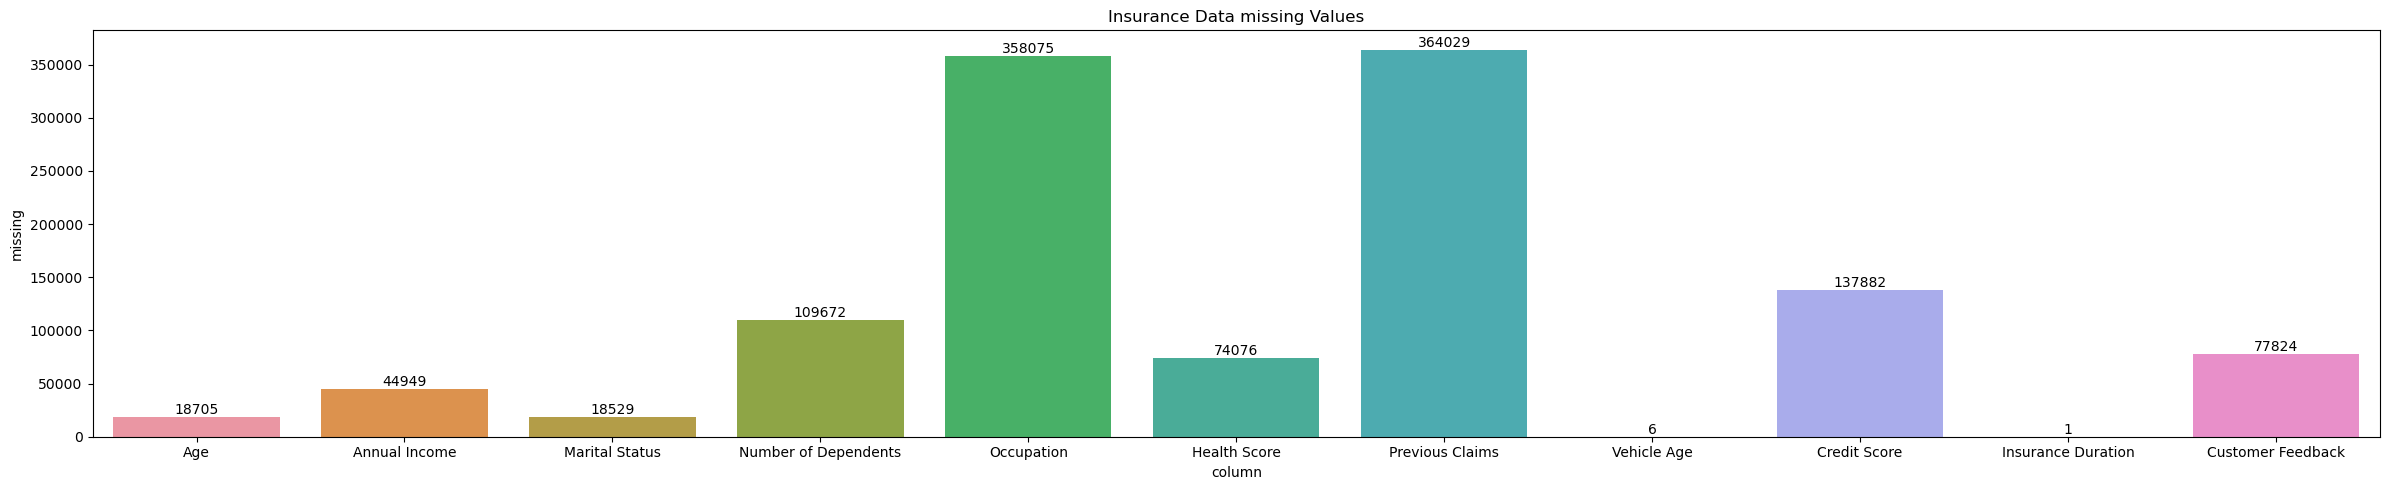

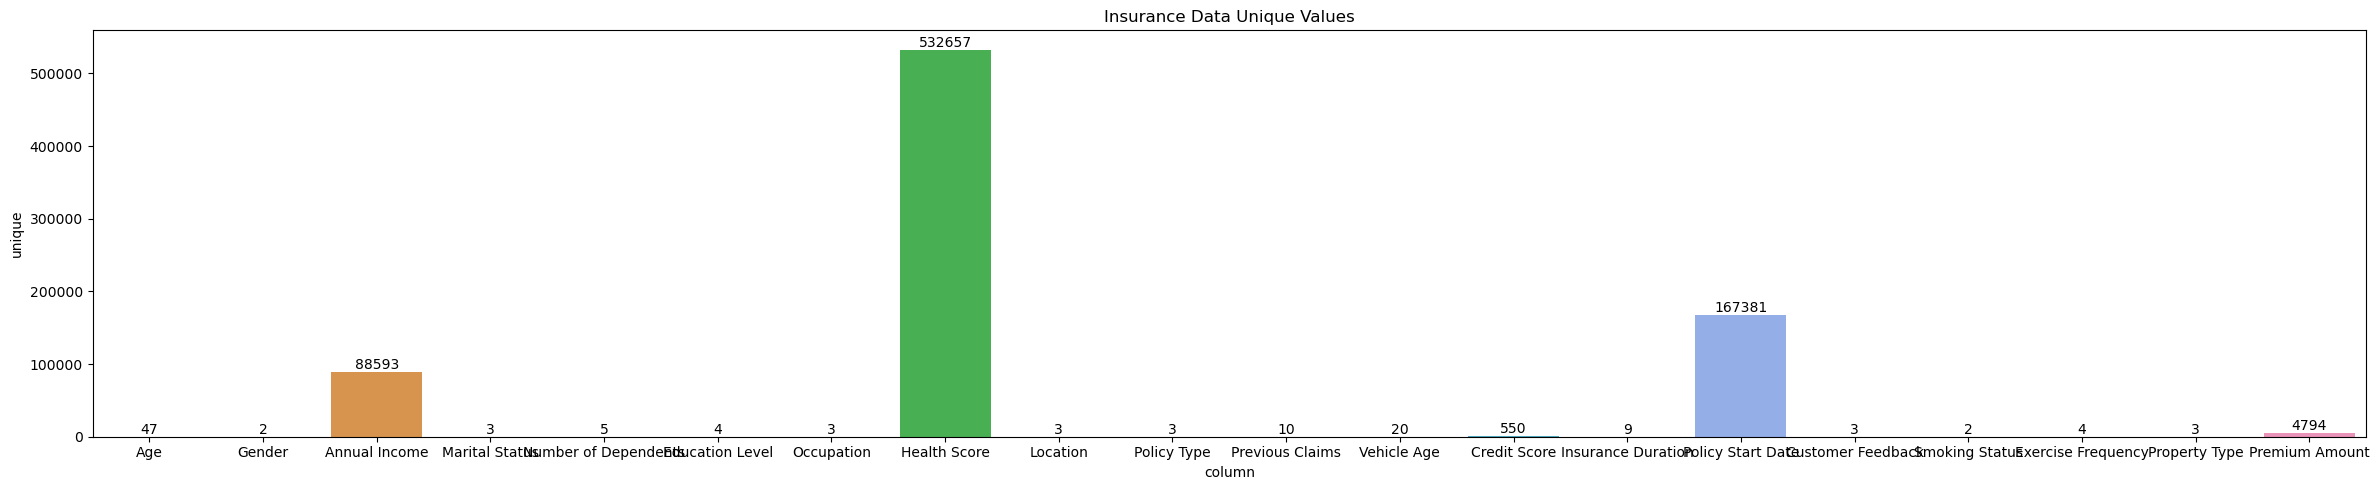

In [43]:
describe_dataframe(df_train, name='Insurance Data', nrows=0, plots=True, info=True)

In [44]:
def clean_dataframe(df_to_use: pd.DataFrame) -> None:
    df = df_to_use.copy()
    
    # inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    # df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})  
    # # Merge the two DataFrames on 'column'
    # inf['missing'] = df_missing['missing'] 
    # Filter columns where the type is either 'float' or 'int' and there are missing values
    numeric_cols = df.select_dtypes(include=[np.float64, np.int64]).columns
    missing_numeric_columns = [
        col for col in numeric_cols if df[col].isnull().sum() > 0
    ]

    # Fill nulls in numeric columns with the median
    for column in missing_numeric_columns:
        mdn = df[column].median()
    # Currently not filling nulls as it improved the model
        df[column] = df[column].fillna(mdn)

    
    # Get object columns
    object_columns = df.select_dtypes(include=['object', 'string']).columns.tolist()  
    # Fill missing values in object columns
    for column in object_columns:
        df[column] = df[column].fillna('Unknown')
    # Convert object columns to string
    for column in object_columns:
        df[column] = df[column].astype('string')
    
    return df

In [45]:
df_train_cleaned = clean_dataframe(df_train)

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,0,0.000000,47,0,18.000000,64.000000,41.143294,13.434020,nan,nan
1,Gender,string,0,0.000000,2,0,nan,nan,nan,nan,Male,602571
2,Annual Income,float64,0,0.000000,88593,0,1.000000,149997.000000,32414.310064,31615.603456,nan,nan
3,Marital Status,string,0,0.000000,4,0,nan,nan,nan,nan,Single,395391
4,Number of Dependents,float64,0,0.000000,5,0,0.000000,4.000000,2.009026,1.351022,nan,nan
5,Education Level,string,0,0.000000,4,0,nan,nan,nan,nan,Master's,303818
6,Occupation,string,0,0.000000,4,0,nan,nan,nan,nan,Unknown,358075
7,Health Score,float64,0,0.000000,532658,0,2.012237,58.975914,25.550001,11.823428,nan,nan
8,Location,string,0,0.000000,3,0,nan,nan,nan,nan,Suburban,401542
9,Policy Type,string,0,0.000000,3,0,nan,nan,nan,nan,Premium,401846


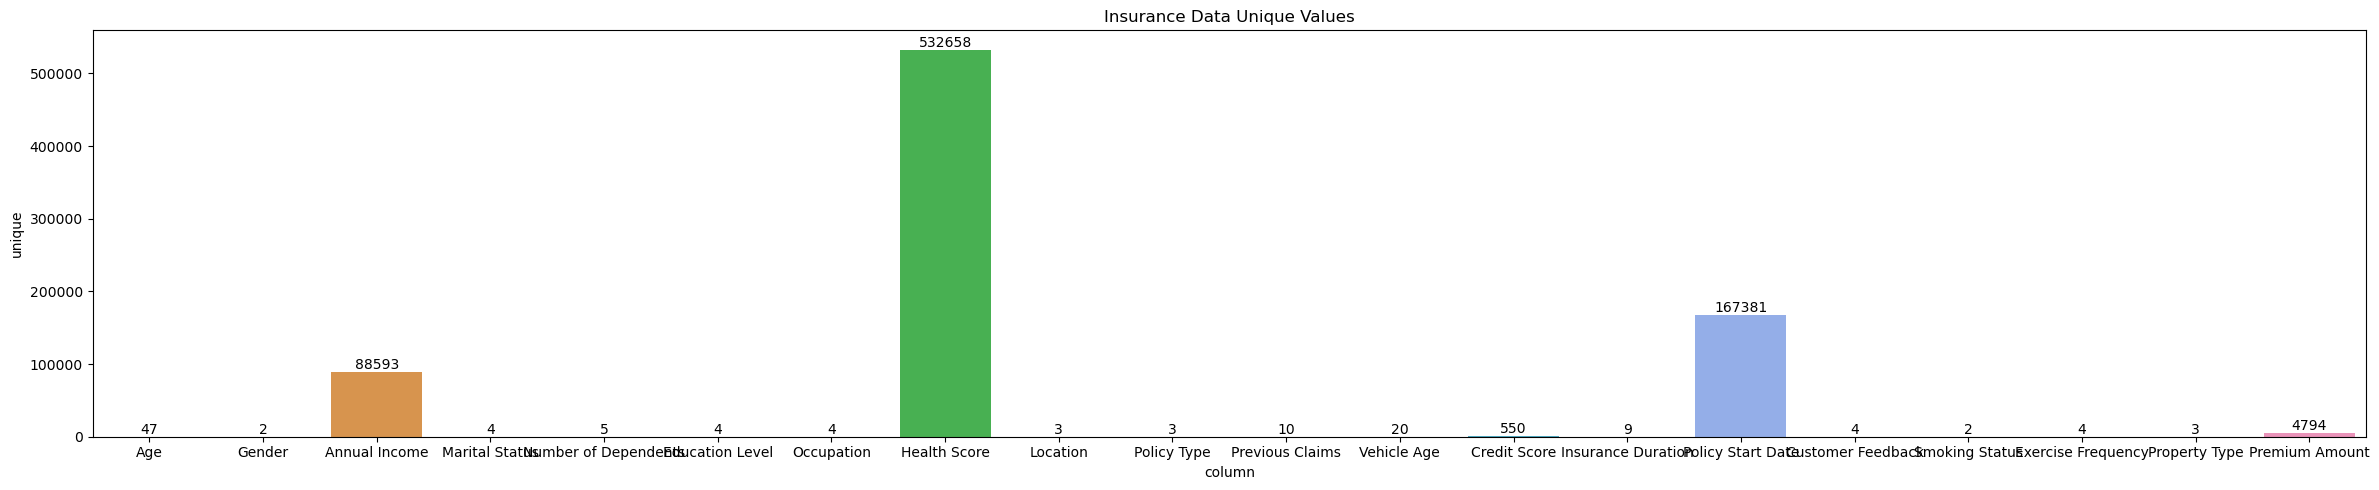

In [46]:
describe_dataframe(df_train_cleaned, name='Insurance Data', nrows=0, plots=True, info=True)

In [47]:
def transform_dataframe(df_to_use: pd.DataFrame) -> None:
    
    df = df_to_use.copy()
    
    # Transform Date Fields
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month Name'] = df['Policy Start Date'].dt.month_name()
    df['Day of Week'] = df['Policy Start Date'].dt.day_name()
    #df['Week'] = df['Policy Start Date'].dt.isocalendar().week.astype('int32')
    df['Year Sin'] = np.sin(2 * np.pi * df['Year'])
    #df['Year Cos'] = np.cos(2 * np.pi * df['Year'])
    df['Month Sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month Cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day Sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day Cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    #df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7
    
    df = df.drop('Policy Start Date', axis=1)


    # List of columns to encode
    columns_to_encode = [
        'Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
        'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
        'Property Type','Month Name','Day of Week'
    ]
    
    # Apply frequency encoding to Categories
    for col in columns_to_encode:
        # Get the column names before encoding
        existing_columns = set(df.columns)
        
        freq_encoding = df[col].value_counts()  # Count occurrences
        df[f'{col}_Freq'] = df[col].map(freq_encoding).astype('int32')  # Map frequencies to the original data
        
        
    df = df.drop(columns=columns_to_encode, axis=1)

    df['Annual Income'] = np.log(df['Annual Income']) + 1
    
    return df

In [48]:
df_train_prepared = transform_dataframe(df_train_cleaned)

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev
0,Age,float64,0,0.000000,47,0,18.000000,64.000000,41.143294,13.434020
1,Annual Income,float64,0,0.000000,88593,0,1.000000,12.918371,10.779008,1.330075
2,Number of Dependents,float64,0,0.000000,5,0,0.000000,4.000000,2.009026,1.351022
3,Health Score,float64,0,0.000000,532658,0,2.012237,58.975914,25.550001,11.823428
4,Previous Claims,float64,0,0.000000,10,0,0.000000,9.000000,1.001873,0.820329
5,Vehicle Age,float64,0,0.000000,20,0,0.000000,19.000000,9.569891,5.776174
6,Credit Score,float64,0,0.000000,550,0,300.000000,849.000000,593.162846,141.104056
7,Insurance Duration,float64,0,0.000000,9,0,1.000000,9.000000,5.018219,2.594330
8,Premium Amount,float64,0,0.000000,4794,0,20.000000,4999.000000,1102.544822,864.998859
9,Year,int32,0,0.000000,6,0,2019.000000,2024.000000,2021.620870,1.476008


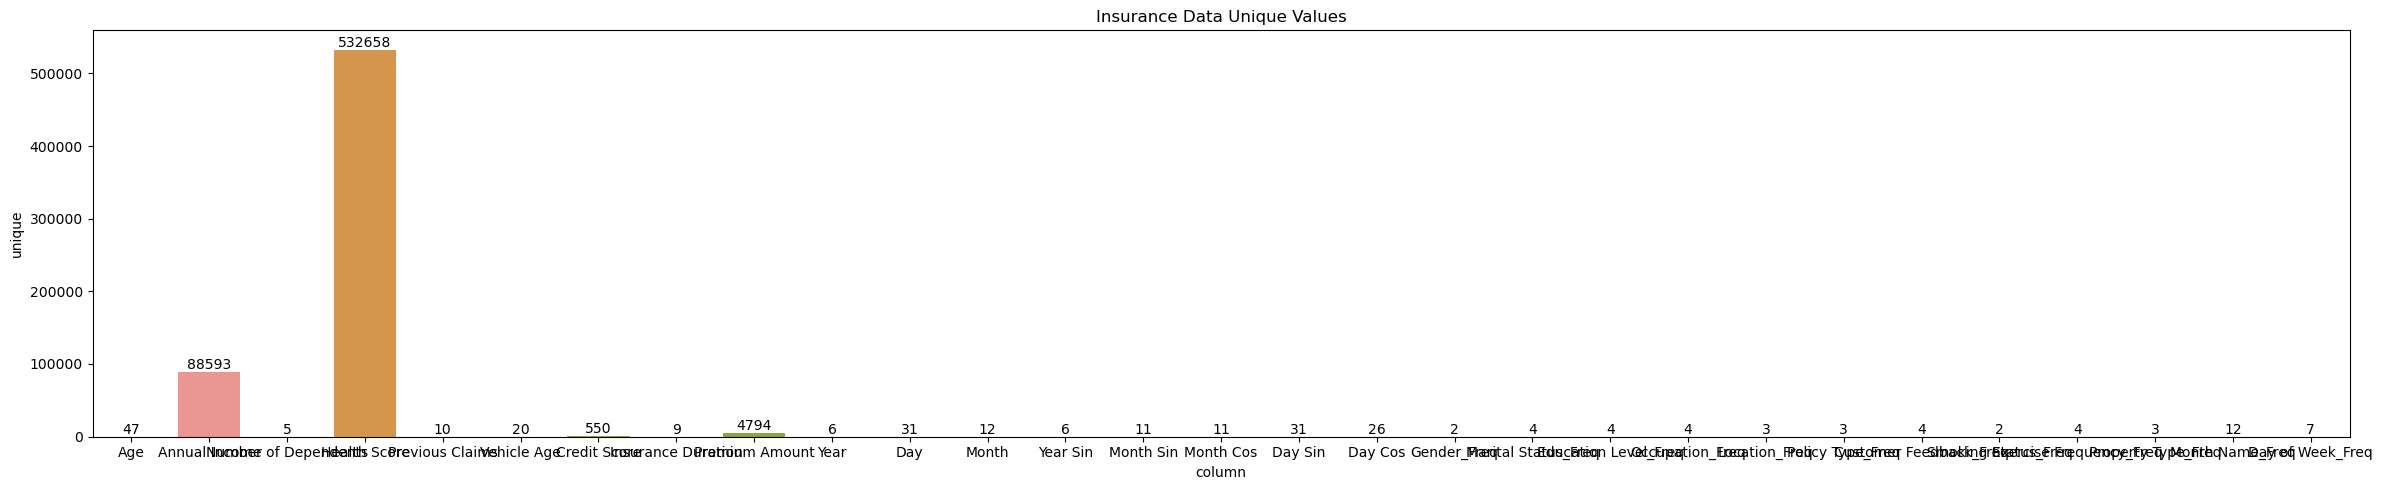

In [49]:
describe_dataframe(df_train_prepared, name='Insurance Data', nrows=0, plots=True, info=True)

'\nPositive Corr: \n    Credit Score / Annual Income\n    Premium Amount / Previous Claims\n    Year / Group (too high, should remove)\n    Week / Month (too high, should remove)\n'

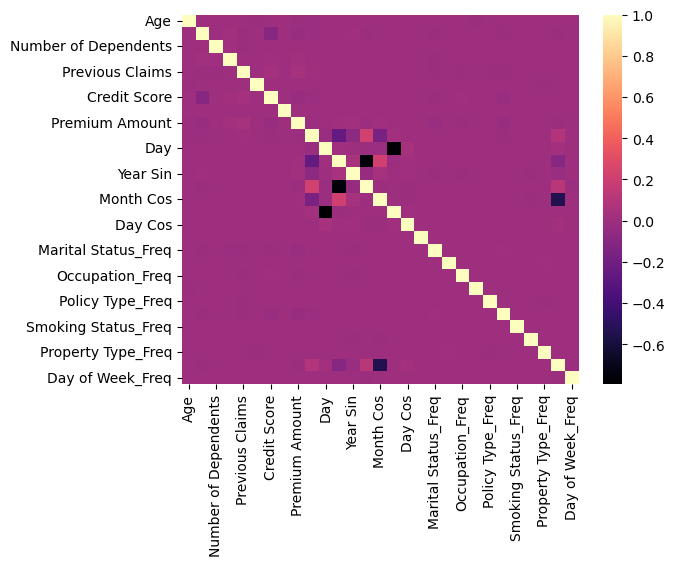

In [50]:
sns.heatmap(df_train_prepared.corr(), annot=False, cmap='magma')
"""
Positive Corr: 
    Credit Score / Annual Income
    Premium Amount / Previous Claims
    Year / Group (too high, should remove)
    Week / Month (too high, should remove)
"""

In [51]:
from sklearn.model_selection import train_test_split

# Split into 80% training data and 20% testing data

X = df_train_prepared.drop('Premium Amount', axis=1)
y = df_train_prepared['Premium Amount'].copy()

X_train_initial, X_test, y_train_initial, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Now split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_initial, y_train_initial, test_size=0.25, random_state=SEED)


y_log_train = np.log1p(y_train)
y_log_val = np.log1p(y_val)
y_log_test = np.log1p(y_test)

In [52]:
# Pipeline constructor used to run transformation steps in order
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

# Fit and transform training data
X_train_prepared= num_pipeline.fit_transform(X_train)

# Transform validation and test data using the same pipeline
X_val_prepared= num_pipeline.fit_transform(X_val)
X_test_prepared= num_pipeline.fit_transform(X_test)



In [53]:
from keras import backend as K
from sklearn.metrics import mean_squared_log_error

#Define a custom RMSLE metric
def rmsle(y_true, y_pred):  
    # To avoid log(0), clip values to a small positive constant (epsilon)
    epsilon = tf.keras.backend.epsilon()

    # Apply log transformation
    #y_true_log = tf.math.log1p(y_true)  # Log-transform the true values
    #y_pred_log = tf.math.log1p(y_pred)  # Log-transform the clipped predicted values
    
    # RMSLE formula
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [54]:
from tensorflow import keras
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [55]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Parameter grid
param_grid = {
    'max_depth': [1, 5, 10],        # limit on depth
    'learning_rate': [0.01,.001,.0001], # Step size for updates
    'n_estimators': [200, 500, 1000], # Number of boosting rounds
}

xgb = XGBRegressor(random_state=SEED)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Use RMSE as the evaluation metric
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Output progress messages
    n_jobs=-1  # Use all available cores
)

grid_search.fit(X_train_prepared, y_log_train)

best_params = grid_search.best_params_
best_rmse = (-grid_search.best_score_) ** 0.5

print("Best parameters:",best_params)
print("Best RMSE:", best_rmse)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
Best RMSE: 1.0496627921813988


In [56]:
print("Best parameters:",best_params)
print("Best RMSE:", best_rmse)

Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
Best RMSE: 1.0496627921813988


In [57]:

# Initialize the XGBRegressor
xgb = XGBRegressor(
    **best_params,
    random_state=SEED        # Ensure reproducibility
)

# Train the model
xgb.fit(
    X_train_prepared, 
    y_log_train, 
    eval_set=[(X_val_prepared, y_log_val)],
    verbose=0
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=69, ...)

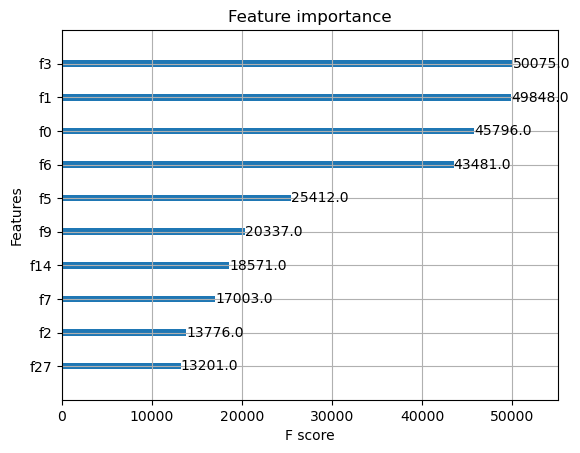

In [58]:
from xgboost import plot_importance
#Plot feature importance
plot_importance(xgb, importance_type='weight', max_num_features=10)  # 'weight', 'gain', 'cover' are possible importance types
plt.show()

In [59]:
# Predict on test set
y_pred = xgb.predict(X_test_prepared)

In [60]:
from sklearn.metrics import root_mean_squared_error

# Calculate RMSE
rmse = root_mean_squared_error(y_log_test, y_pred)
print(f"RMSE: {rmse:.5f}")

RMSE: 1.05835


<Axes: >

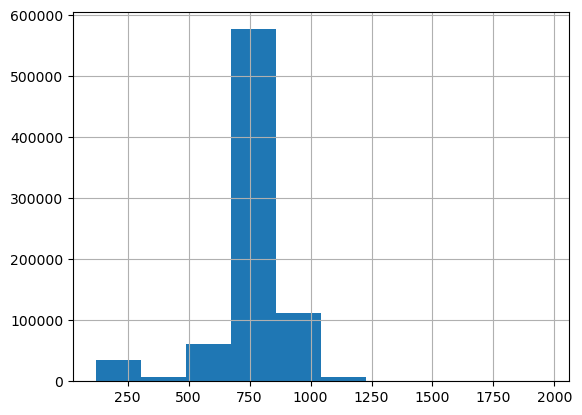

In [61]:
# Create final predictions
df_solve_cleaned = clean_dataframe(df_solve)
df_solve_prepared = transform_dataframe(df_solve_cleaned)
X_solve_prepared= num_pipeline.fit_transform(df_solve_prepared)

y_log_solve = xgb.predict(X_solve_prepared)

y_solve = np.expm1(y_log_solve)  # Inverse of log1p (to get the original scale)

df_y_solve = pd.DataFrame(y_solve, columns=['Premium Amount'])
df_final = pd.merge(df_solve_id, df_y_solve, left_index=True, right_index=True, how='inner')
df_final.to_csv('Predictions.csv', index=False)

df_final['Premium Amount'].hist()

In [62]:
# Best RMSE = 1.05835

In [ ]:
'''
THIS MODEL IS APPARENTLY WRONG SINCE I"M USING fit_transform for the scalars, but it performs the best. 
trying to understand why
'''